In [19]:
################################################################################################################################################### 
# METHOD: Two-stage Least Squares (2SLS)
# GOAL: Estimate a linear model using more than one instrumental variable
# DATE: 9/24/2023
# DATA: Wooldridge's 401k data 
# AUTHOR: Gonzalo Martín Respighi Grasso
################################################################################################################################################

# First, we install and import pandas as pd
# pip install pandas - I cannot install it here so I do it in the command line
import pandas as pd
import numpy as np
import itertools
import math
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### PART 1: UNDERSTANDING AND CLEANING THE DATA ###
### STEP 1A: CHECKING DIMENSIONS AND NULL VALUES ###

# Now we load the data base in a DataFrame 
data = pd.read_excel('401k_data.xls')

# Checking dimensions: 1534 rows (observations) nd 8 columns (variables)
print("Data base dimensions:", data.shape)

# Show information about datatypes and no-null values. We can see that some of them are float64, another are int64,
# but most importantly any of them has a null value
print("\nData types and no-null values:")
print(data.info())

Data base dimensions: (1534, 8)

Data types and no-null values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   prate    1534 non-null   float64
 1   mrate    1534 non-null   float64
 2   totpart  1534 non-null   int64  
 3   totelg   1534 non-null   int64  
 4   age      1534 non-null   int64  
 5   totemp   1534 non-null   int64  
 6   sole     1534 non-null   int64  
 7   ltotemp  1534 non-null   float64
dtypes: float64(3), int64(5)
memory usage: 96.0 KB
None


In [3]:
### STEP 1B: CHECKING MISSING VALUES ###

# Now we review missing values per column. data.isnull() creates a boolean dataframe of the same size as data in which
# each cell is true if the value of the cell corresponds to data and 0 otherwise.
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Fortunately, there are no missing values in any of our columns (variables)



Missing values per column:
prate      0
mrate      0
totpart    0
totelg     0
age        0
totemp     0
sole       0
ltotemp    0
dtype: int64


In [4]:
### STEP 1C: REMOVE DUPLICATES ###
# Verify and eliminate duplicate rows
data.drop_duplicates(inplace=True)

# Verify again dimensions after removing duplicates  
print("\nDimensions after deleting duplicates:", data.shape)



Dimensions after deleting duplicates: (1532, 8)


In [5]:
### STEP 1D: DATA DESCRIPTION ###
# Display the first few rows of the data
print("First few rows of the data:")
print(data.head())

# Get information about the columns and data types
print("\nInformation about columns and data types:")
print(data.info())

# Get basic descriptive statistics for the numeric columns
print("\nBasic descriptive statistics for numeric columns:")
print(data.describe())


First few rows of the data:
        prate  mrate  totpart  totelg  age  totemp  sole   ltotemp
0   26.100000   0.21     1653    6322    8    8709     0  9.072112
1  100.000000   1.42      262     262    6     315     1  5.752573
2   97.599998   0.91      166     170   10     275     1  5.616771
3  100.000000   0.42      257     257    7     500     0  6.214608
4   82.500000   0.53      591     716   28     933     1  6.838405

Information about columns and data types:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1532 entries, 0 to 1533
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   prate    1532 non-null   float64
 1   mrate    1532 non-null   float64
 2   totpart  1532 non-null   int64  
 3   totelg   1532 non-null   int64  
 4   age      1532 non-null   int64  
 5   totemp   1532 non-null   int64  
 6   sole     1532 non-null   int64  
 7   ltotemp  1532 non-null   float64
dtypes: float64(3), int64(5)
memory usage

In [6]:
### STEP 1E: HANDLING OUTLIERS ###
# We select columns based on their datatypes. 
# Numeric columns is an object that contains a list of names of columns that are numerics, that are extracted using
# select_dtypes and accessed via columns' name.
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Let's loop over each column in numeric_columns
for column in numeric_columns:
    Q1 = data[column].quantile(0.25) # first quartile 
    Q3 = data[column].quantile(0.75) # third quartile
    IQR = Q3 - Q1 # interquartile range
    
    # Now, replace values
    outliers_replaced = data[column].apply(lambda x: data[column].median() if x < (Q1 - 1.5 * IQR) or x > (Q3 + 1.5 * IQR) else x)
    
    # Count how many were replaced
    outliers_count = (outliers_replaced != data[column]).sum()
    total_values = len(data[column])
    percentage_replaced = (outliers_count / total_values)*100
      
    # Print results
    print(f"For {column}, {outliers_count} outliers were replaced ({percentage_replaced:.2f}%)")


    

For prate, 42 outliers were replaced (2.74%)
For mrate, 156 outliers were replaced (10.18%)
For totpart, 200 outliers were replaced (13.05%)
For totelg, 215 outliers were replaced (14.03%)
For age, 67 outliers were replaced (4.37%)
For totemp, 203 outliers were replaced (13.25%)
For sole, 0 outliers were replaced (0.00%)
For ltotemp, 40 outliers were replaced (2.61%)


In [7]:
### STEP 1F: CODIFYING CATEGORICAL VARIABLES ###
# With this code, we label each categorical variable of our dataset

# Storage list and run loop to identify categorical variables
categorical_columns = []
for column in data.columns:
    if data[column].nunique() < 10:  # We could adjust this limit as needed
        categorical_columns.append(column)

# Print identified categorical columns
print("Categorical columns identified:")
print(categorical_columns)

# Applying label encoding to categorical columns identified
label_encoder = LabelEncoder()
for column in categorical_columns:
    data[column] = label_encoder.fit_transform(data[column])


Categorical columns identified:
['sole']


In [8]:
### STEP 1G: NORMALIZATION AND STANDARIZATION OF DATA ###

scaler = StandardScaler()

# We first identify features to scale and then we standarize them with fit_transform 
features_to_scale = data.select_dtypes(include=['float64', 'int64']).columns
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

## Now our data is different: each column has mean 0 and standard deviation 1 to ease comparison. Let's check it

# Now we compute mean and standard deviation for ecah variable
means = data.mean()
std_devs = data.std()
print(means)
print(std_devs)

prate     -3.932161e-16
mrate     -1.666784e-18
totpart    1.084859e-16
totelg    -7.981540e-17
age       -3.177035e-16
totemp     2.736153e-17
sole       1.046450e-16
ltotemp   -1.845782e-16
dtype: float64
prate      1.000327
mrate      1.000327
totpart    1.000327
totelg     1.000327
age        1.000327
totemp     1.000327
sole       1.000327
ltotemp    1.000327
dtype: float64


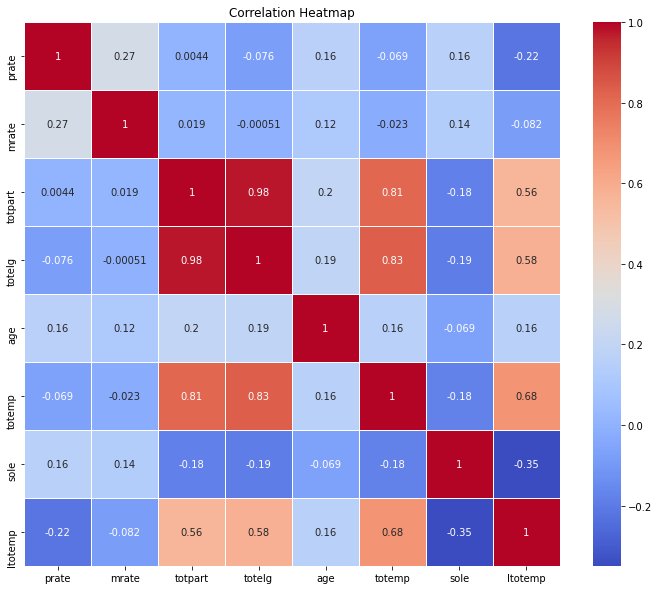

In [9]:
### STEP 1H.1: CORRELATION ANALYSIS ###
# Create correlation matrix
correlation_matrix = data.corr()

# Plotting a heatmap for visualization
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Let's now proceed to eliminate variables that have a high (higher than 0.8) correlation with the others


In [10]:
### STEP 1.H2: MULTICOLLINEARITY ###

# First, let's define a threshold and storage list
correlation_threshold = 0.8
highly_correlated_features = []

# Find highly correlated pairs
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.append((correlation_matrix.columns[j], colname))

print("Pairs of variables highly correlated:")
for pair in highly_correlated_features:
    print(pair)
    
# Now let's eliminate one of the variables that are highly correlated

for pair in highly_correlated_features:
    feature1, feature2 = pair
    try:
        data.drop(feature1, axis=1, inplace=True)
    except KeyError:
        # the column exists, ignore it
        pass

print("Variables after eliminating highly correlated:")
print(data.columns)


Pairs of variables highly correlated:
('totpart', 'totelg')
('totpart', 'totemp')
('totelg', 'totemp')
Variables after eliminating highly correlated:
Index(['prate', 'mrate', 'age', 'totemp', 'sole', 'ltotemp'], dtype='object')


In [11]:
# STEP 1.G: FEATURE SELECTION
# Let's denote "X" the feature matrix and "y" the response variable
columns_to_drop = ['mrate', 'age', 'totemp', 'sole', 'ltotemp', 'prate']  # Exclude prate (endogenous)
# Remove the columns to drop
X = data.drop(columns_to_drop, axis=1)
y = data['prate']

# Check if there's at least one feature to select
if X.shape[1] > 0:
    # Assuming you want to select all features
    selector = SelectKBest(score_func=f_classif, k='all')  # Select all features
    
    # Check if there are any features left to select
    if X.shape[1] >= selector.k:
        X_new = selector.fit_transform(X, y)  # Assuming 'prate' is the target variable

        # Get the mask of selected features (True for selected features, False for unselected)
        selected_mask = selector.get_support()

        # Get the names of the selected features (excluding the endogenous variable)
        selected_features = X.columns[selected_mask]

        print("Selected exogenous features:")
        print(selected_features)
    else:
        print("Not enough exogenous features to select.")
else:
    print("No exogenous features to select.")


ValueError: Found array with 0 feature(s) (shape=(1532, 0)) while a minimum of 1 is required.

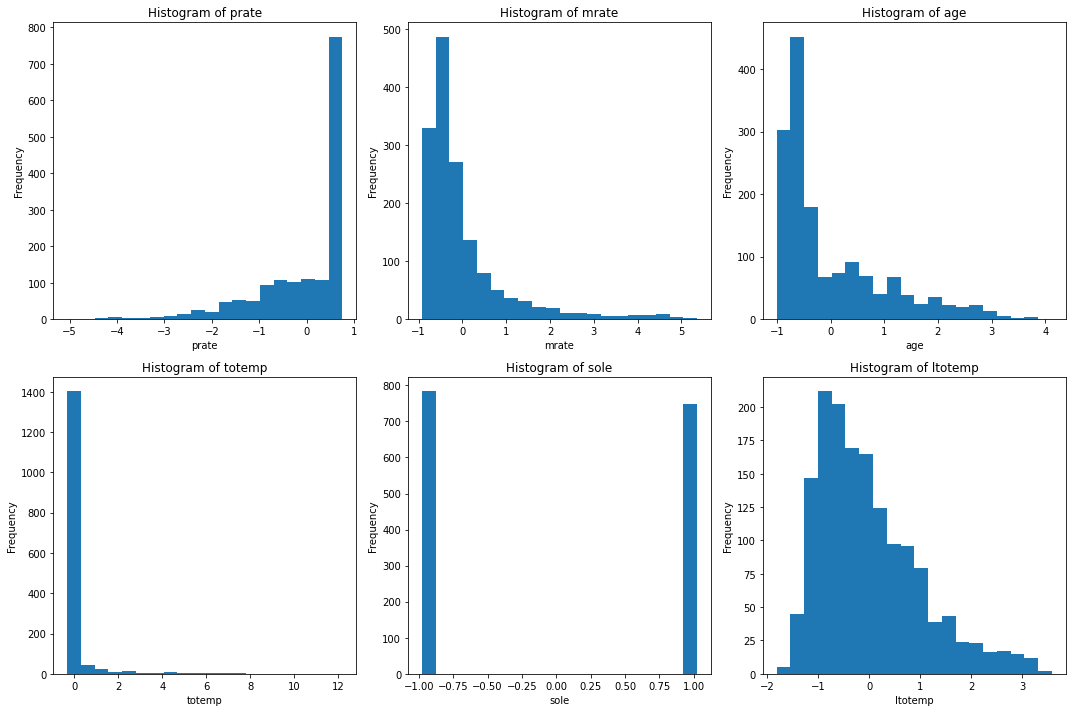

In [14]:
### STEP 1.H1: DATA VISUALIZATION ###

# Obtain first numerical values
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Establish size of subgraphic matrix as a function of the number of columns
num_cols = len(numeric_columns)
num_rows = int(np.ceil(num_cols / 3)) 

# Creating subplot matrix
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Iterate over numeric columns creating an histogram for each
for i, column in enumerate(numeric_columns):
    ax = axes[i // 3, i % 3]  # Selecciona el eje correspondiente
    ax.hist(data[column], bins=20)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

# Ajusta el diseño
plt.tight_layout()

# Muestra los histogramas
plt.show()


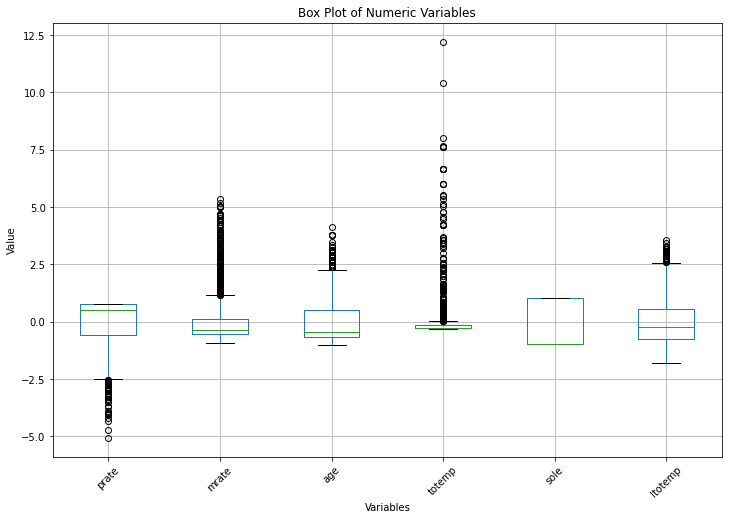

In [15]:
### STEP 1.H2: BOXPLOTS ###

# Assuming numeric_columns contains the names of numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Create a boxplot for each numeric variable
plt.figure(figsize=(12, 8))
data[numeric_columns].boxplot()
plt.xlabel('Variables')
plt.ylabel('Value')
plt.title('Box Plot of Numeric Variables')
plt.xticks(rotation=45)  # Rotating x-axis labels for better visibility
plt.show()


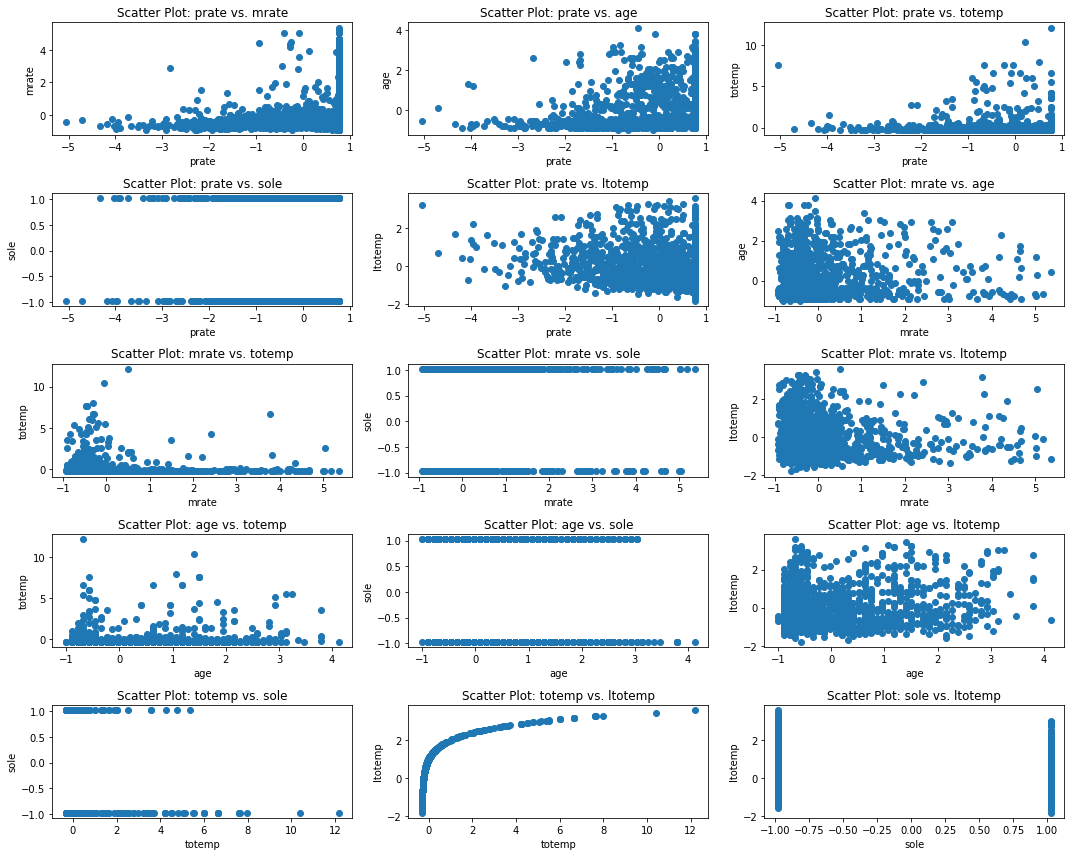

In [20]:
### STEP 1.H3: SCATTERPLOTS ###

import itertools

# Assuming numeric_columns contains the names of numeric columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Generate combinations of 2 variables
variable_combinations = list(itertools.combinations(numeric_columns, 2))

# Determine the layout of subplots
num_plots = len(variable_combinations)
cols = 2 if num_plots <= 2 else 3
rows = math.ceil(num_plots / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

# Flatten the axes if necessary
axes = axes.flatten()

# Plot each combination
for i, combination in enumerate(variable_combinations):
    if i < num_plots:
        var1, var2 = combination
        ax = axes[i]
        ax.scatter(data[var1], data[var2])
        ax.set_xlabel(var1)
        ax.set_ylabel(var2)
        ax.set_title(f'Scatter Plot: {var1} vs. {var2}')
    else:
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [23]:
### STEP 2: HANDLING CLASS IMBALANCE ###
# One way to deal with this is using oversampling (you can choose a different strategy)
from imblearn.over_sampling import SMOTE
oversampler = SMOTE()
X_resampled, y_resampled = oversampler.fit_resample(X, y)

ModuleNotFoundError: No module named 'imblearn'

  Attempting uninstall: joblib
    Found existing installation: joblib 0.14.1
    Uninstalling joblib-0.14.1:
      Successfully uninstalled joblib-0.14.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
Note: you may need to restart the kernel to use updated packages.


ERROR: islp 0.3.17 has requirement scikit-learn>=1.2, but you'll have scikit-learn 1.0.2 which is incompatible.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Acceso denegado: 'c:\\users\\eduardo\\anaconda3\\lib\\site-packages\\~cipy\\cluster\\_hierarchy.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

